**Author:** **Ritesh** **Chowdhry**
## **Description**: 
In this notebook I have created a CNN Model for training Fashion_MNIST dataset. The dataset has been imported from datasets module in torchvision pytorch.  
 
### Second cell:
*   In the second cell I have written all the utility functions, model and training function. 
*   The training function also has the code for plotting loss and accuracy plots and early stopping (which requires validation == True in training function so, validation set is required for that).

### Last cell:
It has to code for testing the model on test dataset and plot confusion matrix.


---


### To do:


1.   Experiment and prepare a literature of comparison in model performance for different hyperparamters.
>> Optimizer (SGD and Adam)  
>> Loss function (Cross entropy and MSE)  
>> Learning rate 




2. Include validation for early stopping and prepare evidence that it stops at the right step.  




 
  


In [1]:
#Importing the libraries

import pandas as pd
import numpy as np

# Pytorch modules used in my code.

import torch

from torch import nn
from torch.utils.data import DataLoader

from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Conv2d

from torchvision import transforms
from torchvision import datasets

# These modules are which I've used for results visulaization.
from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix
from matplotlib import pyplot as plt
import time

# This is just for interfacing the training progress.
from tqdm.autonotebook import tqdm

In [2]:
# This cell has all the utility functions, model and training function.

# CNN_model used in this notebook.
class network(nn.Module):
  def __init__(self):
    super(network, self).__init__()
    self.layer1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
    # self.layer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),nn.ReLU(),nn.MaxPool2d(kernel_size=2, stride=2))
    # self.drop_out = nn.Dropout(p=0.6)
    # self.fc1 = nn.Linear(7 * 7 * 64, 1000)
    self.fc1 = nn.Linear(14 * 14 * 32, 1000)
    self.fc2 = nn.Linear(1000, 10)
  def forward(self, x):
    x = self.layer1(x)
    # x = self.layer2(x)
    x = x.reshape(x.size(0), -1)
    # x = self.drop_out(x)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

# Train the model
def training(train_dataloader, model, learning_rate, num_epochs,start_time = 0.0,loss_function = "Cross Entropy",optimizer_choice = "SGD", validation = False, validation_loader = None, plots = False):

  log_train_loss = []
  log_train_accuracy = []
  log_valid_loss = []
  log_valid_accuracy = []
  epoch_plot_values = []

  # Loss and optimizer
  if(loss_function == "Cross Entropy"):
    criterion = nn.CrossEntropyLoss()
  elif(loss_function == "MSE"):
    criterion = nn.MSELoss()
  
  if(optimizer_choice == "SGD"):
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=learning_rate/4)
  elif(optimizer_choice == "adam"):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  
  

  for epoch in range(num_epochs):
    train_mean_loss = 0
    train_mean_acc = 0
    rand_var = 0
    
    
    for i, (train_images, train_label) in enumerate(train_dataloader):
      """
      rand_var += 1
      if(rand_var == 10):
        break
      """
      # Run the forward pass
      train_output = model(train_images)
      loss = criterion(train_output, train_label)
      train_mean_loss +=loss.item()

      train_acc = calc_accuracy(train_output,train_label)
      train_mean_acc += train_acc 

      # Backprop and perform Adam optimisation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if(validation == True):
        with torch.no_grad():
          valid_mean_loss = 0
          valid_mean_acc = 0
          for valid_input,valid_label in valid_loader:
            # valid_input = valid_input.to(device_available)
            # valid_label = valid_label.to(device_available)
            valid_output = model(valid_input.type(torch.FloatTensor))
            valid_loss = loss_CE(train_output,train_label)
            valid_acc = calc_accuracy(valid_output,valid_label)
            valid_mean_acc += valid_acc
            valid_mean_loss += valid_loss.item() 

    log_train_loss.append((train_mean_loss/len(train_dataloader)))
    log_train_accuracy.append((train_mean_acc/len(train_dataloader)))
    if(validation == True):
      log_valid_loss.append((valid_mean_loss/len(valid_loader)))
      log_valid_accuracy.append((valid_mean_acc/len(valid_loader)))

    epoch_plot_values.append(epoch)
    
    print("Epoch:",epoch)
    print("Training Loss:",train_mean_loss/len(train_dataloader))
    print("Training accuracy:", (train_mean_acc/len(train_dataloader)), "%")
    if(validation == True):
      print("Validation loss:", valid_mean_loss/len(valid_loader))
      print("Valdation Accuracy:", valid_mean_acc/len(valid_loader),"%")
    print("*******************************************************")
    ############################ Early_stopping_condtion ############
    if(validation == True): 
      if((valid_mean_acc/len(valid_loader)) == 100):
        print("Validation accuracy reached 100%, stopping early.")
        break
      elif(len(log_valid_loss)>20):
        if(log_valid_loss[-20]<(sum(log_valid_loss[-20:])/20)):
          print(sum(log_valid_loss[-20:])/20)
          print("Validation loss started to increase, stopping early.")
          break

  if(plots == True):
    end_time = time.time()
    f1 = plt.figure(1)
    ax1 = f1.add_subplot(111)

    accuracy_graph_scale = (max(log_train_accuracy) - min(log_train_accuracy))/10
    y_for_accuracy_graph = min(log_train_accuracy)

    loss_graph_scale = (max(log_train_loss) - min(log_train_loss))/10
    y_for_loss_graph = min(log_train_loss)

    plot_x_limit = num_epochs - (1.5+num_epochs/10)

    f2 = plt.figure(2)
    ax2 = f2.add_subplot(111)

    learning_rate_str = "Learning rate: " + str(learning_rate)
    loss_str = "Loss: " + str(loss_function)
    optimizer_str = "Optimizer: " + str(optimizer_choice)
    time_elapsed = "Training Time: "+str(round((end_time - start_time)/60,2)) + " min"

    ax1.plot(epoch_plot_values,log_train_loss, '-b', label = 'Train loss')
    if(validation == True):
        ax1.plot(epoch_plot_values,log_valid_loss, '-r', label = 'Validation loss')
        ax1.set_title("Train and Validation losses")
    else:
        ax1.set_title("Train loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.text(plot_x_limit,y_for_loss_graph + 2 * loss_graph_scale, learning_rate_str, ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
    ax1.text(plot_x_limit,y_for_loss_graph + 3 * loss_graph_scale, loss_str, ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
    ax1.text(plot_x_limit,y_for_loss_graph + 4 * loss_graph_scale, optimizer_str, ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
    ax1.text(plot_x_limit,y_for_loss_graph + 5 * loss_graph_scale, time_elapsed, ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})

    ax2.plot(epoch_plot_values,log_train_accuracy, '-b', label = 'Train Accuracy')
    if(validation == True):
        ax2.plot(epoch_plot_values,log_valid_accuracy, '-r', label = 'Validation Accuracy')
        ax2.set_title("Train and Validation accuracy")
    else:
        ax2.set_title("Train accuracy")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")

    ax2.text(plot_x_limit,y_for_accuracy_graph, learning_rate_str, ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
    ax2.text(plot_x_limit,y_for_accuracy_graph + accuracy_graph_scale, loss_str, ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
    ax2.text(plot_x_limit,y_for_accuracy_graph + 2 * accuracy_graph_scale, optimizer_str, ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
    ax2.text(plot_x_limit,y_for_accuracy_graph + 3 * accuracy_graph_scale, time_elapsed, ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
    plt.legend()
    plt.show()
  
def calc_accuracy(prediction_tensor, true_val_tensor):
  # This function is just to calculate the accuracy given the prediction and the true value of a batch of data.
  prediction_tensor = torch.log_softmax(prediction_tensor, dim = 1)
  _, max_idx = torch.max(prediction_tensor, dim = 1)

  true_val = true_val_tensor.tolist()
  predicted_val = max_idx.cpu().numpy()

  correct_count = 0
  for i in range(len(true_val)):
      
      if(predicted_val[i]==true_val[i]):
          correct_count += 1

  accuracy = (correct_count / len(true_val))*100 
  return accuracy
  


def confusion_matrix_plot(c_matrix, classes, title = "Confusion Matrix", bg_color = "silver"):
  # This function if for plotting the confusion matrix.
      
  c_map=plt.cm.Greys
  plt.imshow(c_matrix, interpolation='nearest', cmap=c_map)

  plt.gcf().set_facecolor(bg_color)
  plt.title(title)

  axes = np.arange(len(classes))

  plt.xticks(axes, classes, rotation=45)
  plt.yticks(axes, classes)

  plt.ylabel(' True Image Label')
  plt.xlabel('\n Predicted Label')

  thresh = c_matrix.max() / 2.

  for i in range((c_matrix.shape[0])):
      for j in range((c_matrix.shape[1])):
          if c_matrix[i, j] > thresh:
              text_color = "white"  
          else:
              text_color = "black"
          plt.text(j, i, c_matrix[i, j], horizontalalignment="center", color = text_color)
  plt.show()

def prediction(test_dataloader, model):
  # This function is for predicting with help of the trained model.
  correct_label = []
  prediction_dataset = []
  with torch.no_grad():
    model.eval()
    test_accuracy = 0
    for i,(test_input,label) in enumerate(test_dataloader):
      output = model(test_input.type(torch.FloatTensor))
      accuracy = calc_accuracy(output,label)
      test_accuracy += accuracy
      output = torch.log_softmax(output, dim = 1)
      _, max_idx = torch.max(output, dim = 1)
      prediction_dataset.append(max_idx.cpu().numpy())
      correct_label.append(label.tolist())
          
  prediction_dataset = [pred.squeeze().tolist() for pred in prediction_dataset]
  # print(prediction_dataset)
  # print(correct_label)
  print("Accuracy: ",  test_accuracy/len(test_dataloader))
  return prediction_dataset, correct_label

In [3]:
# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

path_data = "/content"

# MNIST dataset
train_dataset = datasets.FashionMNIST(root=path_data, train=True, transform=trans, download=True)
test_dataset = datasets.FashionMNIST(root=path_data, train=False, transform=trans)

Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw


Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw


Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [4]:
model_train_iteration = 0
model = network()
batch_size = 100

# Changing device to GPU if available.
# model = model.to(device_available)


# train_dataset = my_dataset_class(train_set_name)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
print("Train Loader", len(train_loader))


# test_dataset = my_dataset_class("test.csv")
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
print("Test Loader", len(test_loader))

Train Loader 600
Test Loader 100


In [5]:
# Hyperparameters
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.1
path_model_final_save = "/content/"



Epoch: 0
Training Loss: 0.4995429192483425
Training accuracy: 82.3 %
*******************************************************
Epoch: 1
Training Loss: 0.34406084661682446
Training accuracy: 87.79 %
*******************************************************
Epoch: 2
Training Loss: 0.2988903159399827
Training accuracy: 89.44833333333334 %
*******************************************************
Epoch: 3
Training Loss: 0.27625800353785357
Training accuracy: 90.13833333333334 %
*******************************************************
Epoch: 4
Training Loss: 0.25829448487609624
Training accuracy: 90.72333333333333 %
*******************************************************


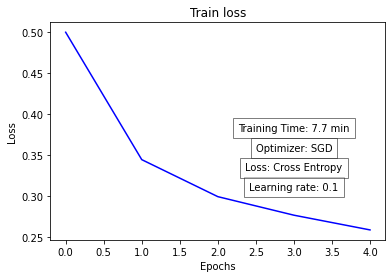

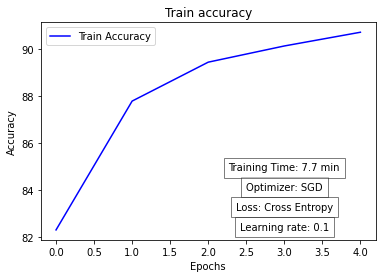

Time elapsed:  7.70459676583608  minutes


In [6]:
begin_time = time.time()
training(train_loader,model, learning_rate, num_epochs,start_time = begin_time, loss_function = "Cross Entropy",optimizer_choice = "SGD", plots = True)
end_time = time.time()
print("Time elapsed: ",(end_time-begin_time)/60," minutes")
model_train_iteration += 1 
# Save the model and plot
model_save_name = "Trained_model" +"_lr:"+str(learning_rate)+"_epochs:"+str(num_epochs) +"_"+ str(model_train_iteration)
torch.save(model.state_dict(), path_model_final_save + model_save_name)

Accuracy:  89.57
 
[[802   0  14  15   2   2 156   0   9   0]
 [  1 970   1  15   6   0   4   0   3   0]
 [ 13   1 842   7  49   0  80   0   8   0]
 [ 11   5  15 885  25   0  52   0   7   0]
 [  1   0  84  20 824   1  67   0   3   0]
 [  0   0   0   0   0 985   0  11   0   4]
 [ 83   1  71  20  55   0 756   0  14   0]
 [  0   0   0   0   0  28   0 961   0  11]
 [  2   0   2   3   1   2   2   4 984   0]
 [  0   0   0   0   0   9   1  42   0 948]]
 


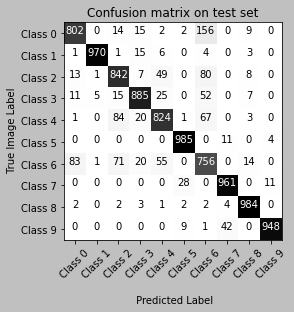

              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1000
           1       0.99      0.97      0.98      1000
           2       0.82      0.84      0.83      1000
           3       0.92      0.89      0.90      1000
           4       0.86      0.82      0.84      1000
           5       0.96      0.98      0.97      1000
           6       0.68      0.76      0.71      1000
           7       0.94      0.96      0.95      1000
           8       0.96      0.98      0.97      1000
           9       0.98      0.95      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [7]:
# Testing cell
# Confusion matrix plot and some other metrics like recall, precision and accuracy.

b_s = test_loader.batch_size
length_loader = len(test_loader)
prediction_dataset, correct_label = prediction(test_loader, model)
length_prediction = b_s*length_loader

prediction_dataset = np.array(prediction_dataset)
prediction_dataset.resize([1,length_prediction])
prediction_dataset.squeeze()
prediction_dataset = prediction_dataset.tolist()
prediction_dataset = prediction_dataset[0]


correct_label = np.array(correct_label)
correct_label.resize([1,length_prediction])
correct_label.squeeze()
correct_label = correct_label.tolist()
correct_label = correct_label[0]

c_matrix = (confusion_matrix(correct_label, prediction_dataset,labels= [0,1,2,3,4,5,6,7,8,9]))

print(" ")
print(c_matrix)
print(" ")
classes = ["Class 0","Class 1","Class 2","Class 3","Class 4","Class 5","Class 6","Class 7","Class 8","Class 9"]
confusion_matrix_plot(c_matrix, classes , title="Confusion matrix on test set" )
print(classification_report(correct_label, prediction_dataset))